In [8]:
import pandas as pd
from pathlib import Path
import json
import seaborn as sns
import matplotlib.pyplot as plt
from Levenshtein import distance

parent_path = Path("/data/jgut/msa-tests")
df = pd.read_csv(parent_path/"porter_data.csv", header=None)

def open_ost(ost_path:Path):
    if not ost_path.exists():
        return -1, -1, -1, -1, -1, -1 ,-1
    with open(ost_path) as json_data:
        score_json = json.load(json_data)
    lddt = score_json["lddt"] if "lddt" in score_json else 0
    bb_lddt = score_json["bb_lddt"] if "bb_lddt" in score_json else 0
    tm_score = score_json["tm_score"] if "tm_score" in score_json else 0
    inconsistent_residues = score_json["inconsistent_residues"] if "inconsistent_residues" in score_json else -1
    length = len(score_json["local_lddt"]) if "local_lddt" in score_json else -1
    model_bad_bonds = len(score_json["reference_bad_bonds"]) if "reference_bad_bonds" in score_json else -1
    model_bad_angles = len(score_json["reference_bad_angles"]) if "reference_bad_angles" in score_json else -1
    return lddt, bb_lddt, tm_score, inconsistent_residues, length, model_bad_bonds, model_bad_angles

def open_secstruc(secstruc_path:Path):
    if not secstruc_path.exists():
        return None, None, -1, -1, -1, -1
    with open(secstruc_path) as json_data:
        json_dict = json.load(json_data)
    secstruc_string = "".join(json_dict["secstruc"])
    sequence_string = "".join(json_dict["residues"])
    gap_total = json_dict["-_total"]
    gap_relative = json_dict["-_rel"]
    return secstruc_string, sequence_string, len(secstruc_string), len(sequence_string), gap_total, gap_relative

In [13]:
scores = []
for it, row in list(df.iterrows()):
    struc_a = row[0]
    struc_b = row[1]
    case_name = struc_a+struc_b
    case_path = parent_path/"aaa_porter_all_models/porter_all_models"/case_name
    for comparison in [struc_a, struc_b]:
        full_path = list(case_path.glob(f"{comparison}*_sec_struc.json"))[0]
        full_secstruc_string, full_sequence_string, full_len_secstruc_string, full_len_sequence_string, full_gap_total, full_gap_relative = open_secstruc(full_path)
        comparison_path = case_path/f"{comparison}_prot_dir_af3"
        for file_path in comparison_path.glob("*score.json"):
            lddt, bb_lddt, tm_score, inconsistent_residues, length, model_bad_bonds, model_bad_angles = open_ost(file_path)
            #curr_secstruc_string, curr_sequence_string, curr_len_secstruc_string, curr_len_sequence_string, curr_gap_total, curr_gap_relative = 
            if lddt>0:
                rank = 6 #int(str(file_path).split("rank_")[1][0:3])
                model = int(str(file_path).split("-it-")[1][0])
                curr_entry = {"struc":comparison, "rank":rank, "model":model, "lddt": lddt,"lddt_bb":bb_lddt,  "tm": tm_score, "inconsistent_residues": inconsistent_residues, "length": length,  "bad_bonds":  model_bad_bonds,  "bad_angles":  model_bad_angles, "nat":False, "typ":"af3"}
                scores.append(curr_entry)
        comparison_path = case_path/f"{comparison}_prot_dir"
        for file_path in comparison_path.glob("*score.json"):
            lddt, bb_lddt, tm_score, inconsistent_residues, length, model_bad_bonds, model_bad_angles = open_ost(file_path)
            curr_secstruc_string, curr_sequence_string, curr_len_secstruc_string, curr_len_sequence_string, curr_gap_total, curr_gap_relative = open_secstruc(Path(str(file_path)[:-len("score.json")]+"sec_struc.json"))
            if lddt>0:
                rank = int(str(file_path).split("rank_")[1][0:3])
                model = int(str(file_path).split("_model_")[1][0])
                curr_entry = {"struc":comparison, "rank":rank, "model":model, "lddt": lddt,"lddt_bb":bb_lddt,  "tm": tm_score, "inconsistent_residues": inconsistent_residues, "length": length,  "bad_bonds":  model_bad_bonds,  "bad_angles":  model_bad_angles, "nat":False, "typ":"af2"}
                levenshtein = distance(full_secstruc_string, curr_secstruc_string)
                curr_entry = curr_entry | {"full_secstruc_string":full_secstruc_string, "full_sequence_string":full_sequence_string, "full_len_secstruc_string": full_len_secstruc_string, "full_len_sequence_string":full_len_sequence_string, "full_gap_total": full_gap_total, "full_gap_relative":full_gap_relative,"levenshtein": levenshtein,"levenshtein_ratio":levenshtein/full_len_sequence_string, "curr_secstruc_string":curr_secstruc_string, "curr_sequence_string":curr_sequence_string, "curr_len_secstruc_string": curr_len_secstruc_string, "curr_len_sequence_string":curr_len_sequence_string, "curr_gap_total": curr_gap_total, "curr_gap_relative":curr_gap_relative}
                scores.append(curr_entry)
        comparison_packed = case_path/f"{comparison}_score_dir_af3_nat"
        for file_path in comparison_packed.glob("*score.json"):
            print(file_path)
            lddt, bb_lddt, tm_score, inconsistent_residues, length, model_bad_bonds, model_bad_angles = open_ost(file_path)
            if lddt>0:
                rank = 6 #int(str(file_path).split("rank_")[1][0:3])
                model = int(str(file_path).split("-it-")[1][0])
                curr_entry = {"struc":comparison, "rank":rank, "model":model, "lddt": lddt,"lddt_bb":bb_lddt,  "tm": tm_score, "inconsistent_residues": inconsistent_residues, "length": length,  "bad_bonds":  model_bad_bonds,  "bad_angles":  model_bad_angles, "nat":True, "typ":"af3"}
                scores.append(curr_entry)
        comparison_path = case_path/f"{comparison}_score_dir_af2_nat"
        for file_path in comparison_path.glob("1inp*score.json"):
            lddt, bb_lddt, tm_score, inconsistent_residues, length, model_bad_bonds, model_bad_angles = open_ost(file_path)
            curr_secstruc_string, curr_sequence_string, curr_len_secstruc_string, curr_len_sequence_string, curr_gap_total, curr_gap_relative = open_secstruc(Path(str(file_path)[:-len("score.json")]+"sec_struc.json"))
            if lddt>0:
                rank = int(str(file_path).split("rank_")[1][0:3])
                model = int(str(file_path).split("_model_")[1][0])
                curr_entry = {"struc":comparison, "rank":rank, "model":model, "lddt": lddt,"lddt_bb":bb_lddt,  "tm": tm_score, "inconsistent_residues": inconsistent_residues, "length": length,  "bad_bonds":  model_bad_bonds,  "bad_angles":  model_bad_angles, "nat":True, "typ":"af2"}
                levenshtein = distance(full_secstruc_string, curr_secstruc_string)
                curr_entry = curr_entry | {"full_secstruc_string":full_secstruc_string, "full_sequence_string":full_sequence_string, "full_len_secstruc_string": full_len_secstruc_string, "full_len_sequence_string":full_len_sequence_string, "full_gap_total": full_gap_total, "full_gap_relative":full_gap_relative,"levenshtein": levenshtein,"levenshtein_ratio":levenshtein/full_len_sequence_string, "curr_secstruc_string":curr_secstruc_string, "curr_sequence_string":curr_sequence_string, "curr_len_secstruc_string": curr_len_secstruc_string, "curr_len_sequence_string":curr_len_sequence_string, "curr_gap_total": curr_gap_total, "curr_gap_relative":curr_gap_relative,}
                scores.append(curr_entry)
                
        comparison_path = case_path/f"{comparison}_prot_dir_packed"
        for file_path in comparison_path.glob("*score.json"):
            lddt, bb_lddt, tm_score, inconsistent_residues, length, model_bad_bonds, model_bad_angles = open_ost(file_path)
            if lddt>0:
                rank = int(str(file_path).split("rank_")[1][0:3])
                model = int(str(file_path).split("_model_")[1][0])
                curr_entry = {"struc":comparison, "rank":rank, "model":model, "lddt": lddt,"lddt_bb":bb_lddt,  "tm": tm_score, "inconsistent_residues": inconsistent_residues, "length": length,  "bad_bonds":  model_bad_bonds,  "bad_angles":  model_bad_angles, "nat":False, "typ":"packed"}
                scores.append(curr_entry)
    
    lddt, bb_lddt, tm_score, inconsistent_residues, length, model_bad_bonds, model_bad_angles = open_ost(case_path/"score_AA_RF.json")
    if lddt>0:
        rank = 6
        model = 0
        curr_entry = {"struc":struc_a, "rank":rank, "model":model, "lddt": lddt,"lddt_bb":bb_lddt,  "tm": tm_score, "inconsistent_residues": inconsistent_residues, "length": length,  "bad_bonds":  model_bad_bonds,  "bad_angles":  model_bad_angles, "nat":True, "typ":"rf"}
        scores.append(curr_entry)
    lddt, bb_lddt, tm_score, inconsistent_residues, length, model_bad_bonds, model_bad_angles = open_ost(case_path/"score_BB_RF.json")
    if lddt>0:
        rank = 6
        model = 0
        curr_entry = {"struc":struc_b, "rank":rank, "model":model, "lddt": lddt,"lddt_bb":bb_lddt,  "tm": tm_score, "inconsistent_residues": inconsistent_residues, "length": length,  "bad_bonds":  model_bad_bonds,  "bad_angles":  model_bad_angles, "nat":True, "typ":"rf"}
        scores.append(curr_entry)
        
    lddt, bb_lddt, tm_score, inconsistent_residues, length, model_bad_bonds, model_bad_angles = open_ost(case_path/"score_Aprot_rf.json")
    if lddt>0:
        rank = 6
        model = 0
        curr_entry = {"struc":struc_a, "rank":rank, "model":model, "lddt": lddt,"lddt_bb":bb_lddt,  "tm": tm_score, "inconsistent_residues": inconsistent_residues, "length": length,  "bad_bonds":  model_bad_bonds,  "bad_angles":  model_bad_angles, "nat":False, "typ":"rf"}
        scores.append(curr_entry)
    lddt, bb_lddt, tm_score, inconsistent_residues, length, model_bad_bonds, model_bad_angles = open_ost(case_path/"score_Bprot_rf.json")
    if lddt>0:
        rank = 6
        model = 0
        curr_entry = {"struc":struc_b, "rank":rank, "model":model, "lddt": lddt,"lddt_bb":bb_lddt,  "tm": tm_score, "inconsistent_residues": inconsistent_residues, "length": length,  "bad_bonds":  model_bad_bonds,  "bad_angles":  model_bad_angles, "nat":False, "typ":"rf"}
        scores.append(curr_entry)

    

/data/jgut/msa-tests/aaa_porter_all_models/porter_all_models/7ahlE4yhdG/7ahlE_score_dir_af3_nat/sample-it-1_score.json
/data/jgut/msa-tests/aaa_porter_all_models/porter_all_models/7ahlE4yhdG/7ahlE_score_dir_af3_nat/sample-it-2_score.json
/data/jgut/msa-tests/aaa_porter_all_models/porter_all_models/7ahlE4yhdG/7ahlE_score_dir_af3_nat/sample-it-3_score.json
/data/jgut/msa-tests/aaa_porter_all_models/porter_all_models/7ahlE4yhdG/7ahlE_score_dir_af3_nat/sample-it-0_score.json
/data/jgut/msa-tests/aaa_porter_all_models/porter_all_models/7ahlE4yhdG/7ahlE_score_dir_af3_nat/sample-it-4_score.json
/data/jgut/msa-tests/aaa_porter_all_models/porter_all_models/7ahlE4yhdG/4yhdG_score_dir_af3_nat/sample-it-1_score.json
/data/jgut/msa-tests/aaa_porter_all_models/porter_all_models/7ahlE4yhdG/4yhdG_score_dir_af3_nat/sample-it-2_score.json
/data/jgut/msa-tests/aaa_porter_all_models/porter_all_models/7ahlE4yhdG/4yhdG_score_dir_af3_nat/sample-it-3_score.json
/data/jgut/msa-tests/aaa_porter_all_models/porte

In [14]:
pd.set_option('display.max_columns', None)
scores = pd.DataFrame(scores)
#sec_struc_df = pd.read_csv(parent_path/"sec_struc.csv")
#sec_struc_df["struc"] = sec_struc_df["pdb_path"].str.slice(18,23)
#sec_struc_df = sec_struc_df.set_index("struc")
#scores = scores.join(sec_struc_df[["-_total", "-_rel"]], on="struc")
all_strucs = [struc for struc in df[0]]+[struc for struc in df[1]]
af3_nat_strucs = scores[(scores["typ"]=="af3")&(scores["nat"]==True)].struc.unique()
print(f"AF3 nat missing:{set(all_strucs)-set(af3_nat_strucs)}")
af3_prot_strucs = scores[(scores["typ"]=="af3")&(scores["nat"]==False)].struc.unique()
print(f"AF3 prot missing:{set(all_strucs)-set(af3_prot_strucs)}")
af2_nat_strucs = scores[(scores["typ"]=="af2")&(scores["nat"]==True)].struc.unique()
print(f"AF2 nat missing:{set(all_strucs)-set(af2_nat_strucs)}")
af2_prot_strucs = scores[(scores["typ"]=="af2")&(scores["nat"]==False)].struc.unique()
print(f"AF2 prot missing:{set(all_strucs)-set(af2_prot_strucs)}")
rf_nat_strucs = scores[(scores["typ"]=="rf")&(scores["nat"]==True)].struc.unique()
print(f"RF nat missing:{set(all_strucs)-set(rf_nat_strucs)}")
rf_prot_strucs = scores[(scores["typ"]=="rf")&(scores["nat"]==False)].struc.unique()
print(f"RF prot missing:{set(all_strucs)-set(rf_prot_strucs)}")
print(f'{len(scores[scores["full_gap_relative"]>=0.5].struc.unique())}/180 conformations have more than 50% IDR.')

AF3 nat missing:set()
AF3 prot missing:set()
AF2 nat missing:set()
AF2 prot missing:set()
RF nat missing:{'4zt0C', '4cmqB'}
RF prot missing:{'4zt0C', '4cmqB'}
74/180 conformations have more than 50% IDR.


In [15]:
scores.head()

,struc,rank,model,lddt,lddt_bb,tm,inconsistent_residues,length,bad_bonds,bad_angles,nat,typ,full_secstruc_string,full_sequence_string,full_len_secstruc_string,full_len_sequence_string,full_gap_total,full_gap_relative,levenshtein,levenshtein_ratio,curr_secstruc_string,curr_sequence_string,curr_len_secstruc_string,curr_len_sequence_string,curr_gap_total,curr_gap_relative
0,7ahlE,6,1,0.856,0.957,0.625,[],293,0,0,False,af3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7ahlE,6,2,0.851,0.947,0.665,[],293,0,0,False,af3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7ahlE,6,3,0.870,0.973,0.625,[],293,0,0,False,af3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7ahlE,6,0,0.866,0.964,0.596,[],293,0,0,False,af3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7ahlE,6,4,0.873,0.959,0.632,[],293,0,0,False,af3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
scores[(scores["full_gap_relative"]>=0.5)&~(scores["lddt"]>=0.7)&~(scores["levenshtein"].isnull())][["struc","lddt","tm","levenshtein", "levenshtein_ratio", "full_secstruc_string","curr_secstruc_string"]].groupby("struc").agg("min")

,lddt,tm,levenshtein,levenshtein_ratio,full_secstruc_string,curr_secstruc_string
struc,,,,,,
1dzlA,0.452,0.235,15.0,0.441176,----HHHHHHHHHHHHTT-S----------TT--,---------S-TT-TTS-------------GGG-
1mbyA,0.187,0.258,4.0,0.333333,--S---------,--S-------------
1miqB,0.624,0.451,17.0,0.531250,---SSS---GGGT---------B-SSS--B--,---GGG---TTTTS-------EEETTTTEEE-
1mnmA,0.328,0.182,2.0,0.153846,--------SS---,-------------
1mnmB,0.259,0.241,2.0,0.153846,------S---S--,-------------
1nqjB,0.141,0.334,9.0,0.300000,--HHHHHHHHHHHH-----SSS--------,------EE---S---SGGG-----STT-EE-
1qlnA,0.337,0.222,7.0,0.437500,-------STTSSSS--,-----------TTT--
1repC,0.457,0.322,10.0,0.588235,--SSS------HHHH--,-HHHHHHHTS-HHHHT-
1xjtA,0.359,0.800,14.0,0.466667,-TTT--BSS----S----BBTTB-SS----,-TTT--EEEEEE-TTS-EEEETTB-SS---


In [21]:
len(scores["levenshtein"].isnull())

4850

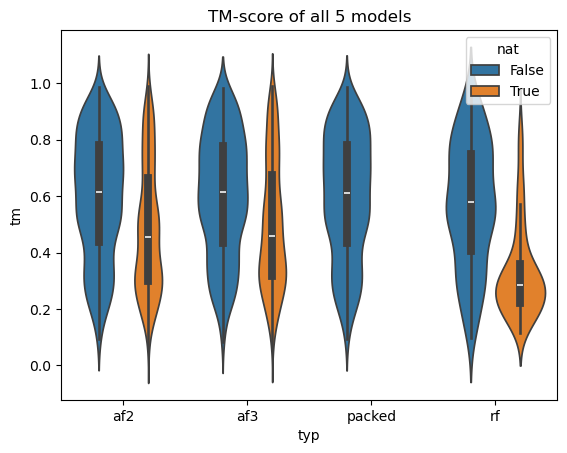

In [4]:
# all models
sns.violinplot(scores.sort_values("typ"), x="typ", y="tm", hue="nat", )
plt.title("TM-score of all 5 models")
plt.show()

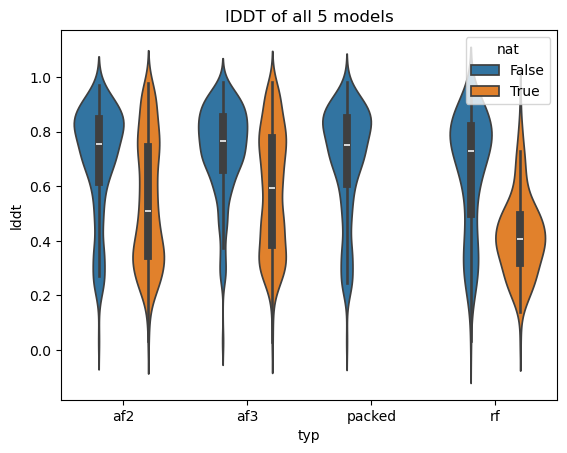

In [5]:
# all models
sns.violinplot(scores.sort_values("typ"), x="typ", y="lddt", hue="nat", )
plt.title("lDDT of all 5 models")
plt.show()

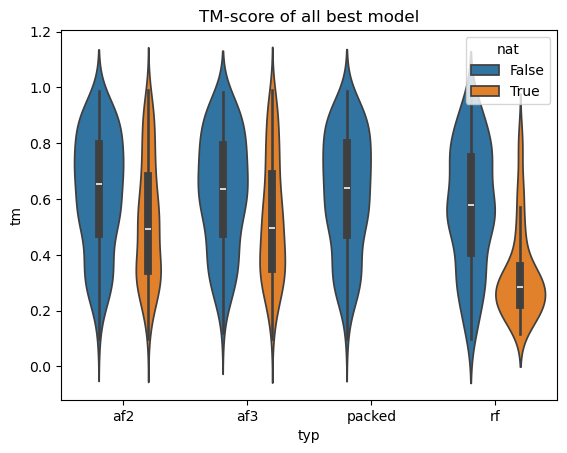

In [6]:
sns.violinplot(scores.groupby(["struc","nat", "typ"]).agg("max"), x="typ", y="tm", hue="nat")
plt.title("TM-score of all best model")
plt.show()

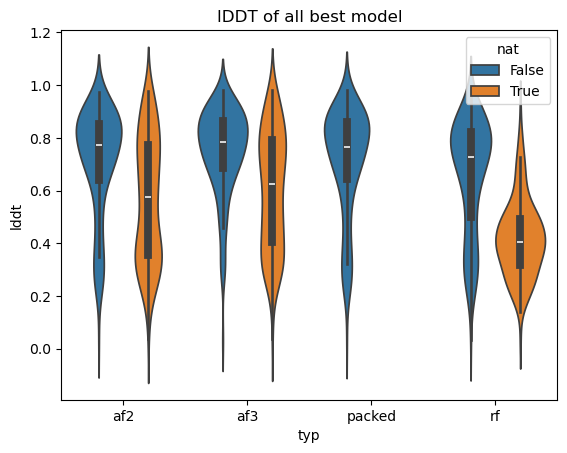

In [7]:
sns.violinplot(scores.groupby(["struc","nat", "typ"]).agg("max"), x="typ", y="lddt", hue="nat")
plt.title("lDDT of all best model")
plt.show()

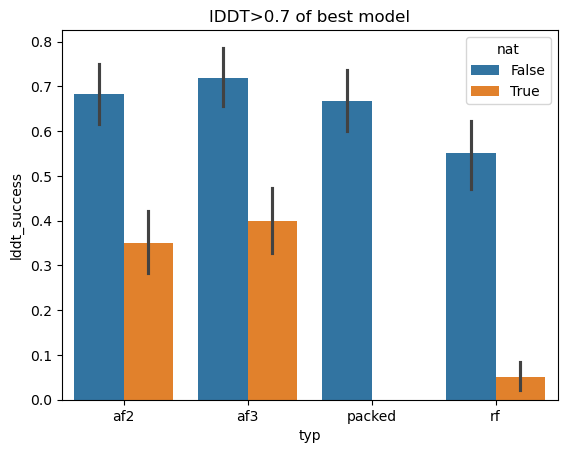

We get 140/180.
mmSeqs gets 77/180.
Together we get 142/180.


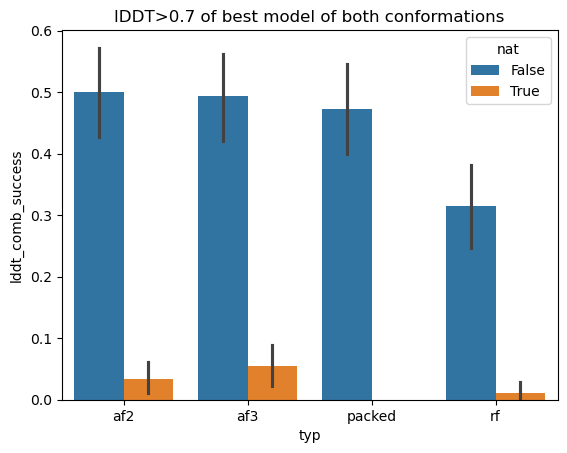

We get 55.0/90 pairs.
mmSeqs gets 6.0/90 pairs.
Together we get 55.0/90 pairs.
not found strucs


,rank,model,lddt,lddt_bb,tm,inconsistent_residues,length,bad_bonds,bad_angles,nat,typ,-_total,-_rel,lddt_success
struc,,,,,,,,,,,,,,
1kctA,6,5,0.695,0.776,0.792,[],375,47,116,True,rf,37.0,0.440476,False
1mbyA,6,5,0.658,0.693,0.532,[],75,5,2,True,rf,11.0,0.916667,False
1mnmA,6,5,0.596,0.860,0.362,"[A.2.-A.2., A.3.-A.3., A.4.-A.4., A.6.-A.6., A...",85,36,19,True,rf,NaN,NaN,False
1mnmB,6,5,0.326,0.860,0.364,"[A.1.-A.1., A.2.-A.2., A.4.-A.4., A.5.-A.5., A...",81,35,21,True,rf,NaN,NaN,False
1nqdA,6,5,0.670,0.709,0.711,"[A.1.-A.1., A.2.-A.2., A.3.-A.3., A.4.-A.4., A...",111,20,43,True,rf,17.0,0.531250,False
1qlnA,6,5,0.360,0.649,0.318,[],862,13,37,True,rf,9.0,0.562500,False
1xtgB,6,5,0.594,0.686,0.487,[],59,72,31,True,rf,29.0,0.725000,False
2axzA,6,5,0.657,0.723,0.843,"[A.292.-A.292., A.294.-A.294., A.295.-A.295., ...",300,17,6,True,rf,7.0,0.875000,False
2jmrA,6,5,0.659,0.782,0.342,[],179,30,18,True,rf,320.0,0.640000,False


In [8]:
scores["lddt_success"] = scores["lddt"]>=0.7
sns.barplot(scores.groupby(["struc","nat", "typ"]).agg("max"), x="typ", y="lddt_success", hue="nat")
plt.title("lDDT>0.7 of best model")
plt.show()
print(f'We get {sum(scores[scores["nat"]==False].groupby(["struc","nat"]).agg("max")["lddt_success"])}/180.')
print(f'mmSeqs gets {sum(scores[scores["nat"]==True].groupby(["struc","nat"]).agg("max")["lddt_success"])}/180.')
print(f'Together we get {sum(scores.groupby(["struc"]).agg("max")["lddt_success"])}/180.')

def find_match(row, df, matches, success_cat):
    curr_struc = row["struc"]
    other_struc = matches[curr_struc]
    other_success = df[(df["struc"]==other_struc) & (df["nat"]==row["nat"]) & (df["typ"]==row["typ"])][["typ","nat","struc",success_cat]].groupby("struc").agg("max")[success_cat]
    if other_success.any():
        return row[success_cat] and other_success.item()
    return False

matches = {row[1][0]: row[1][1] for row in df.iterrows()} | {row[1][1]: row[1][0] for row in df.iterrows()}
grouped = scores[["typ","nat","struc","lddt_success"]].groupby(["struc","nat", "typ"], as_index=False).agg("max")
grouped["lddt_comb_success"] = [find_match(row[1], grouped, matches, "lddt_success")  for row in grouped.iterrows()]
sns.barplot(grouped.groupby(["struc","nat", "typ"]).agg("max"), x="typ", y="lddt_comb_success", hue="nat")
plt.title("lDDT>0.7 of best model of both conformations")
plt.show()

print(f'We get {sum(grouped[grouped["nat"]==False].groupby(["struc","nat"]).agg("max")["lddt_comb_success"])/2}/90 pairs.')
print(f'mmSeqs gets {sum(grouped[grouped["nat"]==True].groupby(["struc","nat"]).agg("max")["lddt_comb_success"])/2}/90 pairs.')
print(f'Together we get {sum(grouped.groupby(["struc"]).agg("max")["lddt_comb_success"])/2}/90 pairs.')
print("not found strucs")
grp = scores.groupby(["struc"]).agg("max")
grp[~(grp["lddt_success"])]

In [14]:
print(len(grp[~(grp["lddt_success"])]))
print(len(grp[(~(grp["lddt_success"])) & (grp["-_rel"]>=0.5)]))

38
24


In [11]:
len(grp["-_rel"]>=0.5)

180

In [10]:
sum(grp["-_rel"]>=0.5)

80

In [ ]:
grp[~(grp["lddt_success"])]

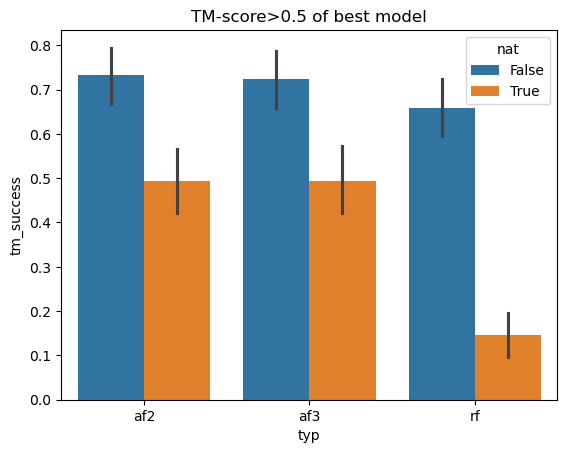

We get 138/180.
mmSeqs gets 105/180.
Together we get 145/180.


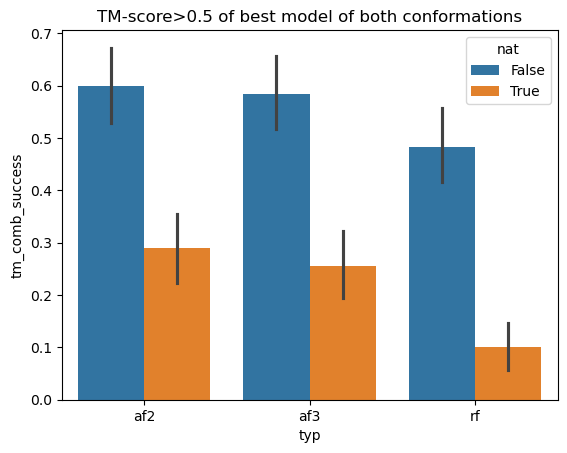

We get 58.0/90 pairs.
mmSeqs gets 34.0/90 pairs.
Together we get 65.0/90 pairs.
not found strucs


,rank,model,lddt,lddt_bb,tm,inconsistent_residues,length,bad_bonds,bad_angles,nat,typ,-_total,-_rel,lddt_success,tm_success
struc,,,,,,,,,,,,,,,
1mnmA,6,5,0.596,0.860,0.362,"[A.2.-A.2., A.3.-A.3., A.4.-A.4., A.6.-A.6., A...",85,3,19,True,rf,NaN,NaN,False,False
1mnmB,6,5,0.326,0.860,0.364,"[A.1.-A.1., A.2.-A.2., A.4.-A.4., A.5.-A.5., A...",81,4,21,True,rf,NaN,NaN,False,False
1qlnA,6,5,0.360,0.649,0.318,[],862,11,37,True,rf,9.0,0.562500,False,False
1xntA,6,5,0.763,0.873,0.484,[],151,10,49,True,rf,230.0,0.434783,True,False
1xtgB,6,5,0.594,0.686,0.487,[],59,0,11,True,rf,29.0,0.725000,False,False
2jmrA,6,5,0.650,0.782,0.342,[],179,3,12,True,rf,320.0,0.640000,False,False
2k0qA,6,5,0.635,0.807,0.373,[],74,2,11,True,rf,220.0,0.478261,False,False
2k42A,6,5,0.740,0.840,0.375,[],72,7,18,True,rf,200.0,0.500000,True,False
2kb8A,6,5,0.749,0.878,0.421,[],37,1,4,True,rf,150.0,0.178571,True,False


In [9]:
scores["tm_success"] = scores["tm"]>=0.5
sns.barplot(scores.groupby(["struc","nat", "typ"]).agg("max"), x="typ", y="tm_success", hue="nat")
plt.title("TM-score>0.5 of best model")
plt.show()
print(f'We get {sum(scores[scores["nat"]==False].groupby(["struc","nat"]).agg("max")["tm_success"])}/180.')
print(f'mmSeqs gets {sum(scores[scores["nat"]==True].groupby(["struc","nat"]).agg("max")["tm_success"])}/180.')
print(f'Together we get {sum(scores.groupby(["struc"]).agg("max")["tm_success"])}/180.')

grouped = scores[["typ","nat","struc","tm_success"]].groupby(["struc","nat", "typ"], as_index=False).agg("max")
grouped["tm_comb_success"] = [find_match(row[1], grouped, matches, "tm_success")  for row in grouped.iterrows()]
sns.barplot(grouped.groupby(["struc","nat", "typ"]).agg("max"), x="typ", y="tm_comb_success", hue="nat")
plt.title("TM-score>0.5 of best model of both conformations")
plt.show()

print(f'We get {sum(grouped[grouped["nat"]==False].groupby(["struc","nat"]).agg("max")["tm_comb_success"])/2}/90 pairs.')
print(f'mmSeqs gets {sum(grouped[grouped["nat"]==True].groupby(["struc","nat"]).agg("max")["tm_comb_success"])/2}/90 pairs.')
print(f'Together we get {sum(grouped.groupby(["struc"]).agg("max")["tm_comb_success"])/2}/90 pairs.')
print("not found strucs")
grp = scores.groupby(["struc"]).agg("max")
grp[~(grp["tm_success"])]

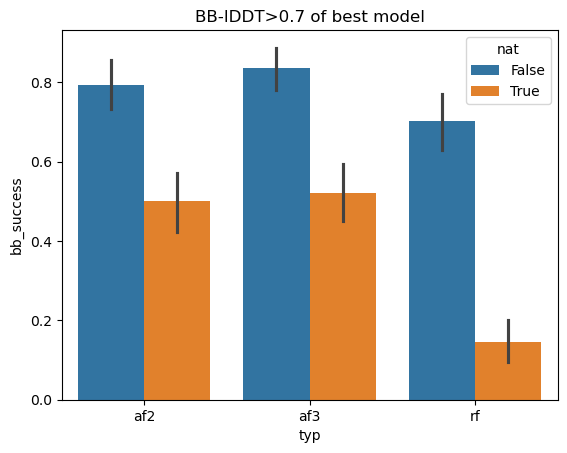

We get 158/180.
mmSeqs gets 104/180.
Together we get 161/180.


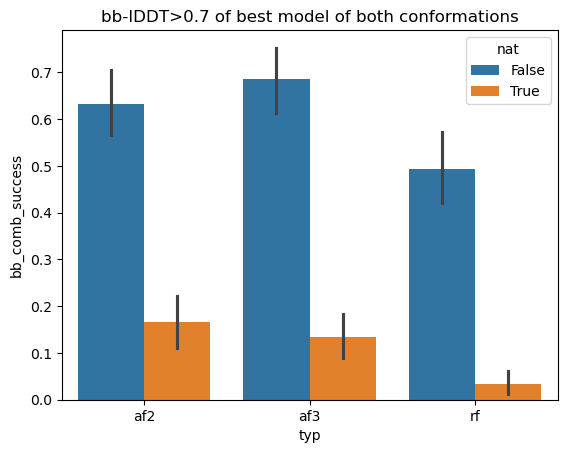

We get 67.0/90 pairs.
mmSeqs gets 17.0/90 pairs.
Together we get 68.0/90 pairs.
not found strucs


,rank,model,lddt,lddt_bb,tm,inconsistent_residues,length,bad_bonds,bad_angles,nat,typ,-_total,-_rel,lddt_success,tm_success,bb_success
struc,,,,,,,,,,,,,,,,
1mbyA,6,5,0.658,0.693,0.532,[],75,2,2,True,rf,11.0,0.916667,False,True,False
1qlnA,6,5,0.360,0.649,0.318,[],862,11,37,True,rf,9.0,0.562500,False,False,False
1xtgB,6,5,0.594,0.686,0.487,[],59,0,11,True,rf,29.0,0.725000,False,False,False
2lelA,6,5,0.541,0.662,0.344,[],74,2,10,True,rf,280.0,0.608696,False,False,False
2n0aD,6,5,0.575,0.665,0.358,[],140,75,241,True,rf,97.0,0.702899,False,False,False
2namA,6,5,0.570,0.643,0.310,[],153,63,171,True,rf,45.0,0.058824,False,False,False
2naoF,6,5,0.471,0.569,0.288,[],42,1,15,True,rf,150.0,0.535714,False,False,False
2nntA,6,5,0.511,0.633,0.313,[],31,1,6,True,rf,110.0,0.366667,False,False,False
2ougC,6,5,0.599,0.697,0.603,"[A.89.-A.89., A.90.-A.90., A.91.-A.91., A.92.-...",141,23,84,True,rf,4.0,0.097561,False,True,False


In [10]:
scores["bb_success"] = scores["lddt_bb"]>=0.7
sns.barplot(scores.groupby(["struc","nat", "typ"]).agg("max"), x="typ", y="bb_success", hue="nat")
plt.title("BB-lDDT>0.7 of best model")
plt.show()
print(f'We get {sum(scores[scores["nat"]==False].groupby(["struc","nat"]).agg("max")["bb_success"])}/180.')
print(f'mmSeqs gets {sum(scores[scores["nat"]==True].groupby(["struc","nat"]).agg("max")["bb_success"])}/180.')
print(f'Together we get {sum(scores.groupby(["struc"]).agg("max")["bb_success"])}/180.')

grouped = scores[["typ","nat","struc","bb_success"]].groupby(["struc","nat", "typ"], as_index=False).agg("max")
grouped["bb_comb_success"] = [find_match(row[1], grouped, matches, "bb_success")  for row in grouped.iterrows()]
sns.barplot(grouped.groupby(["struc","nat", "typ"]).agg("max"), x="typ", y="bb_comb_success", hue="nat")
plt.title("bb-lDDT>0.7 of best model of both conformations")
plt.show()

print(f'We get {sum(grouped[grouped["nat"]==False].groupby(["struc","nat"]).agg("max")["bb_comb_success"])/2}/90 pairs.')
print(f'mmSeqs gets {sum(grouped[grouped["nat"]==True].groupby(["struc","nat"]).agg("max")["bb_comb_success"])/2}/90 pairs.')
print(f'Together we get {sum(grouped.groupby(["struc"]).agg("max")["bb_comb_success"])/2}/90 pairs.')
print("not found strucs")
grp = scores.groupby(["struc"]).agg("max")
grp[~(grp["bb_success"])]

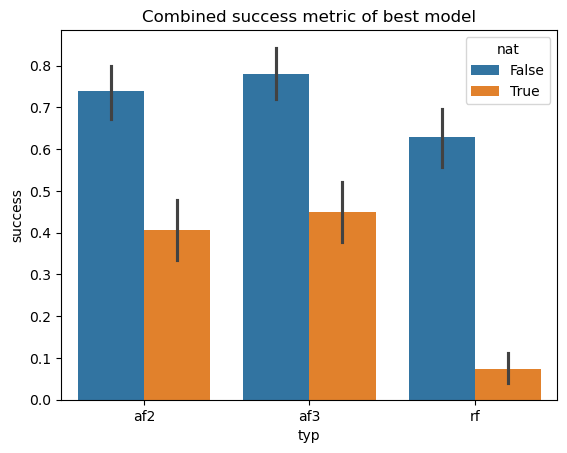

We get 148/180.
mmSeqs gets 89/180.
Together we get 152/180.


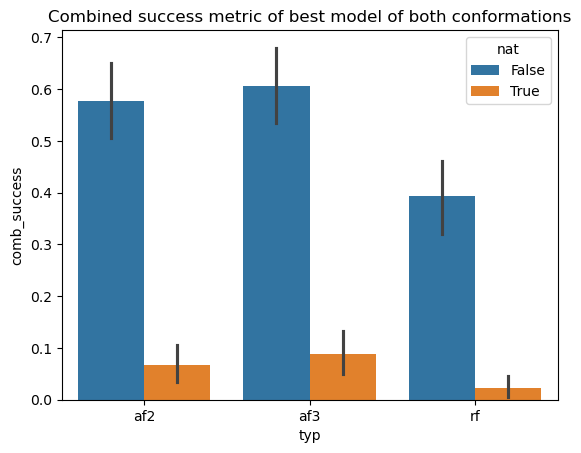

We get 62.0/90 pairs.
mmSeqs gets 11.0/90 pairs.
Together we get 63.0/90 pairs.
not found strucs


,rank,model,lddt,lddt_bb,tm,inconsistent_residues,length,bad_bonds,bad_angles,nat,typ,-_total,-_rel,lddt_success,tm_success,bb_success,success
struc,,,,,,,,,,,,,,,,,
1kctA,6,5,0.695,0.776,0.792,[],375,39,116,True,rf,37.0,0.440476,False,True,True,False
1mbyA,6,5,0.658,0.693,0.532,[],75,2,2,True,rf,11.0,0.916667,False,True,False,False
1mnmA,6,5,0.596,0.860,0.362,"[A.2.-A.2., A.3.-A.3., A.4.-A.4., A.6.-A.6., A...",85,3,19,True,rf,NaN,NaN,False,False,True,False
1mnmB,6,5,0.326,0.860,0.364,"[A.1.-A.1., A.2.-A.2., A.4.-A.4., A.5.-A.5., A...",81,4,21,True,rf,NaN,NaN,False,False,True,False
1qlnA,6,5,0.360,0.649,0.318,[],862,11,37,True,rf,9.0,0.562500,False,False,False,False
1xtgB,6,5,0.594,0.686,0.487,[],59,0,11,True,rf,29.0,0.725000,False,False,False,False
2k0qA,6,5,0.635,0.807,0.373,[],74,2,11,True,rf,220.0,0.478261,False,False,True,False
2lelA,6,5,0.541,0.662,0.344,[],74,2,10,True,rf,280.0,0.608696,False,False,False,False
2n0aD,6,5,0.575,0.665,0.358,[],140,75,241,True,rf,97.0,0.702899,False,False,False,False


In [11]:
scores["success"] = ((scores["lddt_bb"]>=0.7) & (scores["-_rel"]>=0.5)) | ((scores["lddt"]>=0.7) & (scores["-_rel"]<0.5))
sns.barplot(scores.groupby(["struc","nat", "typ"]).agg("max"), x="typ", y="success", hue="nat")
plt.title("Combined success metric of best model")
plt.show()
print(f'We get {sum(scores[scores["nat"]==False].groupby(["struc","nat"]).agg("max")["success"])}/180.')
print(f'mmSeqs gets {sum(scores[scores["nat"]==True].groupby(["struc","nat"]).agg("max")["success"])}/180.')
print(f'Together we get {sum(scores.groupby(["struc"]).agg("max")["success"])}/180.')


grouped = scores[["typ","nat","struc","success"]].groupby(["struc","nat", "typ"], as_index=False).agg("max")
grouped["comb_success"] = [find_match(row[1], grouped, matches, "success")  for row in grouped.iterrows()]
sns.barplot(grouped.groupby(["struc","nat", "typ"]).agg("max"), x="typ", y="comb_success", hue="nat")
plt.title("Combined success metric of best model of both conformations")
plt.show()

print(f'We get {sum(grouped[grouped["nat"]==False].groupby(["struc","nat"]).agg("max")["comb_success"])/2}/90 pairs.')
print(f'mmSeqs gets {sum(grouped[grouped["nat"]==True].groupby(["struc","nat"]).agg("max")["comb_success"])/2}/90 pairs.')
print(f'Together we get {sum(grouped.groupby(["struc"]).agg("max")["comb_success"])/2}/90 pairs.')

print("not found strucs")
grp = scores.groupby(["struc"]).agg("max")
grp[~(grp["success"])]

In [12]:
print(f'AF2 mmseqs success:{sum(scores[(scores["typ"]=="af2") & (scores["nat"]==True) ].groupby(["struc","nat", "typ"]).agg("max")["success"])}')
print(f'AF3 mmseqs success:{sum(scores[(scores["typ"]=="af3") & (scores["nat"]==True) ].groupby(["struc","nat", "typ"]).agg("max")["success"])}')
print(f'RF mmseqs success:{sum(scores[(scores["typ"]=="rf") & (scores["nat"]==True) ].groupby(["struc","nat", "typ"]).agg("max")["success"])}')
print(f'All mmseqs success:{sum(scores[(scores["nat"]==True) ].groupby(["struc","nat"]).agg("max")["success"])}')

print(f'AF2 our success:{sum(scores[(scores["typ"]=="af2") & (scores["nat"]==False) ].groupby(["struc","nat", "typ"]).agg("max")["success"])}')
print(f'AF3 our success:{sum(scores[(scores["typ"]=="af3") & (scores["nat"]==False) ].groupby(["struc","nat", "typ"]).agg("max")["success"])}')
print(f'RF our success:{sum(scores[(scores["typ"]=="rf") & (scores["nat"]==False) ].groupby(["struc","nat", "typ"]).agg("max")["success"])}')
print(f'All our success:{sum(scores[(scores["nat"]==False) ].groupby(["struc","nat"]).agg("max")["success"])}')

print(f'AF2 both success:{sum(scores[(scores["typ"]=="af2")].groupby(["struc"]).agg("max")["success"])}')
print(f'AF3 both success:{sum(scores[(scores["typ"]=="af3")].groupby(["struc"]).agg("max")["success"])}')
print(f'RF both success:{sum(scores[(scores["typ"]=="rf")].groupby(["struc"]).agg("max")["success"])}')
print(f'All both success:{sum(scores.groupby(["struc"]).agg("max")["success"])}')

AF2 mmseqs success:73
AF3 mmseqs success:81
RF mmseqs success:13
All mmseqs success:89
AF2 our success:133
AF3 our success:139
RF our success:112
All our success:148
AF2 both success:135
AF3 both success:145
RF both success:113
All both success:152


In [13]:
#tm_false = scores[scores["nat"]==False].groupby(["struc", "typ"],as_index=False).agg("max")[["struc", "typ", "tm", "lddt", "lddt_bb", "-_total","-_rel"]]
#tm_true = scores[scores["nat"]==True].groupby(["struc", "typ"],as_index=False).agg("max")[["struc", "typ", "tm", "lddt", "lddt_bb", "-_total","-_rel"]]
#scores[scores["nat"]==True].groupby(["struc", "typ"],as_index=False).agg("max")[tm_false<tm_true]
#merged = pd.merge(tm_false, tm_true, "inner", on=["struc", "typ"], suffixes=("_our", "_nat"))

In [14]:
# Different ranks/models nothing too important going on here for now

In [15]:
for rank in range(1,6):
    scores_max_pack = scores[scores["repacked"] & scores["rank"].eq(rank)]
    scores_max_no_pack = scores[~scores["repacked"] & scores["rank"].eq(rank)]
    print(f'Rank {rank}: Passed repacked {len(scores_max_pack[sum([scores_max_pack["tm"]>=0.5]+ [scores_max_pack["lddt"]>=0.7]+[scores_max_pack["lddt_bb"]>=0.7])>0])}')
    print(f'Rank {rank}: Passed normal {len(scores_max_no_pack[sum([scores_max_no_pack["tm"]>=0.5]+ [scores_max_no_pack["lddt"]>=0.7]+[scores_max_no_pack["lddt_bb"]>=0.7])>0])}')

KeyError: 'repacked'

In [ ]:
for model in range(1,6):
    scores_max_pack = scores[scores["repacked"] & ~scores["af3"] & scores["model"].eq(model)]
    scores_max_no_pack = scores[~scores["repacked"] & ~scores["af3"] & scores["model"].eq(model)]
    scores_max_af3 = scores[scores["af3"] & scores["model"].eq(model-1)]
    print(f'Model {model}: Passed repacked {len(scores_max_pack[sum([scores_max_pack["tm"]>=0.5]+ [scores_max_pack["lddt"]>=0.7]+[scores_max_pack["lddt_bb"]>=0.7])>0])}')
    print(f'Model {model}: Passed normal {len(scores_max_no_pack[sum([scores_max_no_pack["tm"]>=0.5]+ [scores_max_no_pack["lddt"]>=0.7]+[scores_max_no_pack["lddt_bb"]>=0.7])>0])}')
    print(f'Model {model}: Passed AF3 {len(scores_max_af3[sum([scores_max_af3["tm"]>=0.5]+ [scores_max_af3["lddt"]>=0.7]+[scores_max_af3["lddt_bb"]>=0.7])>0])}')

In [ ]:
scores_max

In [ ]:
#scores.to_csv(parent_path/"af2_and_dssp.csv")